In [51]:
import pickle
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import operator
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, precision_score
from bayes_opt import BayesianOptimization
from skimage import morphology
from collections import deque

import general_functions

In [44]:
def _get_cluster_array(arr, index, zoneSize):
    """
    Internal function to receive an array of all the pixels of a binary cluster.
    """
    arrayOfPoints = []
    iMax = len(arr) - 1
    jMax = len(arr[0]) - 1
    i = index[0]
    j = index[1]
    FIFOQueue = deque([(i, j)])
    examinedElements = set()
    examinedElements.add((i, j))
    while (len(FIFOQueue) > 0):
        currentIndex = FIFOQueue.popleft()
        i = currentIndex[0]
        j = currentIndex[1]
        if i >= 0 and i < iMax and j >= 0 and j < jMax and arr[i][j] == 1:
            arrayOfPoints.append((i, j))
            # add horizontally and vertically
            if (i+1, j) not in examinedElements:
                FIFOQueue.append((i+1, j))
                examinedElements.add((i+1, j))
            if (i-1, j) not in examinedElements:
                FIFOQueue.append((i-1, j))
                examinedElements.add((i-1, j))
            if (i, j+1) not in examinedElements:
                FIFOQueue.append((i, j+1))
                examinedElements.add((i, j+1))
            if (i, j-1) not in examinedElements:
                FIFOQueue.append((i, j-1))
                examinedElements.add((i, j-1))
            # add diagonally
            if (i+1, j+1) not in examinedElements:
                FIFOQueue.append((i+1, j+1))
                examinedElements.add((i+1, j+1))
            if (i-1, j+1) not in examinedElements:
                FIFOQueue.append((i-1, j+1))
                examinedElements.add((i-1, j+1))
            if (i+1, j-1) not in examinedElements:
                FIFOQueue.append((i+1, j-1))
                examinedElements.add((i+1, j-1))
            if (i-1, j-1) not in examinedElements:
                FIFOQueue.append((i-1, j-1))
                examinedElements.add((i-1, j-1))

            # Add one zone away
            # add horizontally and vertically
            if (i+1 + zoneSize, j) not in examinedElements:
                FIFOQueue.append((i+1 + zoneSize, j))
                examinedElements.add((i+1 + zoneSize, j))
            if (i-1 - zoneSize, j) not in examinedElements:
                FIFOQueue.append((i-1 - zoneSize, j))
                examinedElements.add((i-1 - zoneSize, j))
            if (i, j+1 + zoneSize) not in examinedElements:
                FIFOQueue.append((i, j+1 + zoneSize))
                examinedElements.add((i, j+1 + zoneSize))
            if (i, j-1 - zoneSize) not in examinedElements:
                FIFOQueue.append((i, j-1 - zoneSize))
                examinedElements.add((i, j-1 - zoneSize))
            # add diagonally
            if (i+1 + zoneSize, j+1 + zoneSize) not in examinedElements:
                FIFOQueue.append((i+1 + zoneSize, j+1 + zoneSize))
                examinedElements.add((i+1 + zoneSize, j+1 + zoneSize))
            if (i-1 - zoneSize, j+1 + zoneSize) not in examinedElements:
                FIFOQueue.append((i-1 - zoneSize, j+1 + zoneSize))
                examinedElements.add((i-1 - zoneSize, j+1 + zoneSize))
            if (i+1 + zoneSize, j-1 - zoneSize) not in examinedElements:
                FIFOQueue.append((i+1 + zoneSize, j-1 - zoneSize))
                examinedElements.add((i+1 + zoneSize, j-1 - zoneSize))
            if (i-1 - zoneSize, j-1 - zoneSize) not in examinedElements:
                FIFOQueue.append((i-1 - zoneSize, j-1 - zoneSize))
                examinedElements.add((i-1 - zoneSize, j-1 - zoneSize))
    return arrayOfPoints

In [2]:
results = np.load("../Slutexperiment/predictions.npy")

In [3]:
results.shape

(11, 3, 7852140)

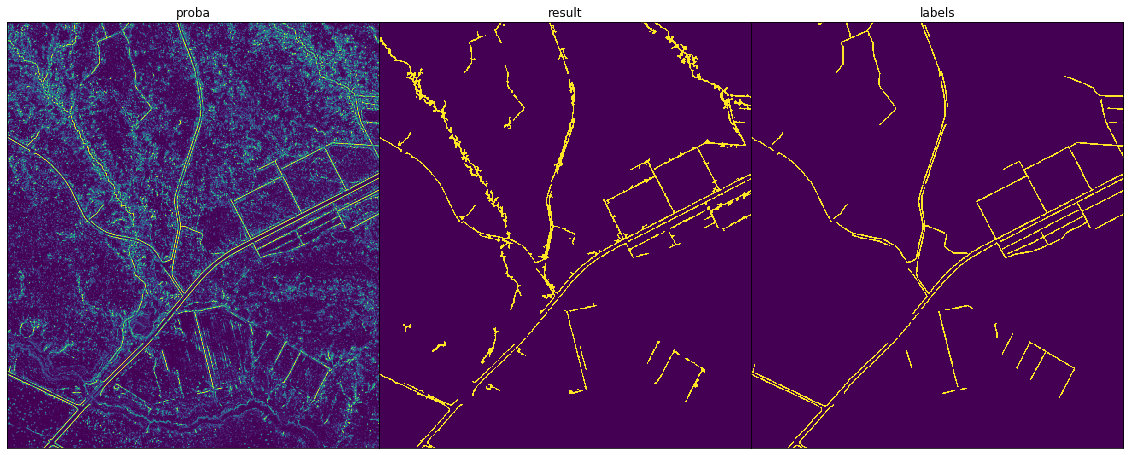

In [23]:
plt.figure(num=None, figsize=(20,15), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,3,i+1) for i in range(3)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

i = 3

ax[0].title.set_text(f"proba")
ax[0].imshow(results[i][0].reshape(2997,2620))
ax[1].title.set_text(f"result")
ax[1].imshow(results[i][1].reshape(2997,2620))
ax[2].title.set_text(f"labels")
ax[2].imshow(results[i][2].reshape(2997, 2620))

In [25]:
result_with_stream = results[3][1].reshape(2997, 2620)

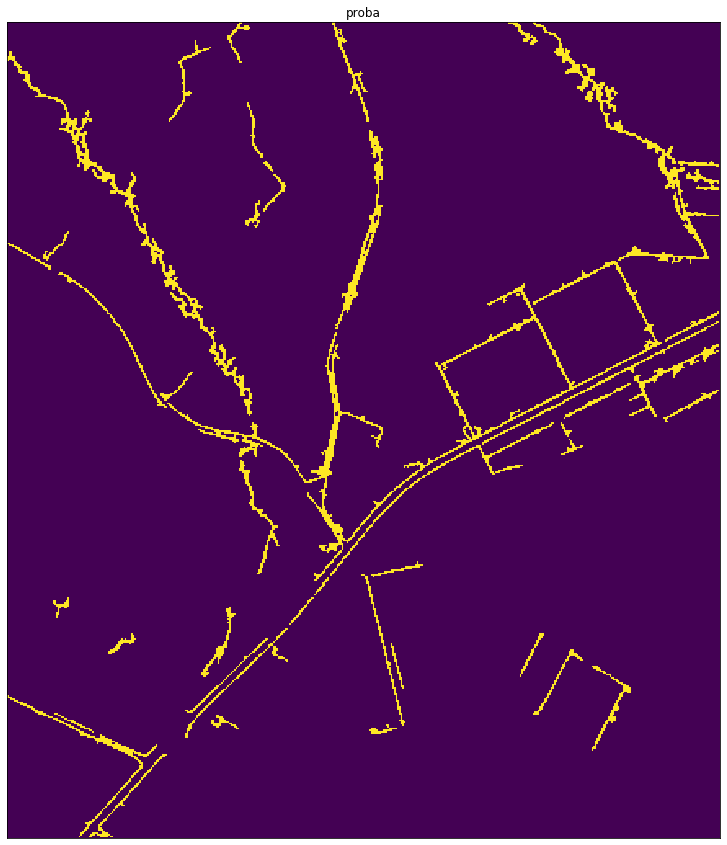

In [35]:
plt.figure(num=None, figsize=(15,15), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

ax[0].title.set_text(f"proba")
ax[0].imshow(result_with_stream)

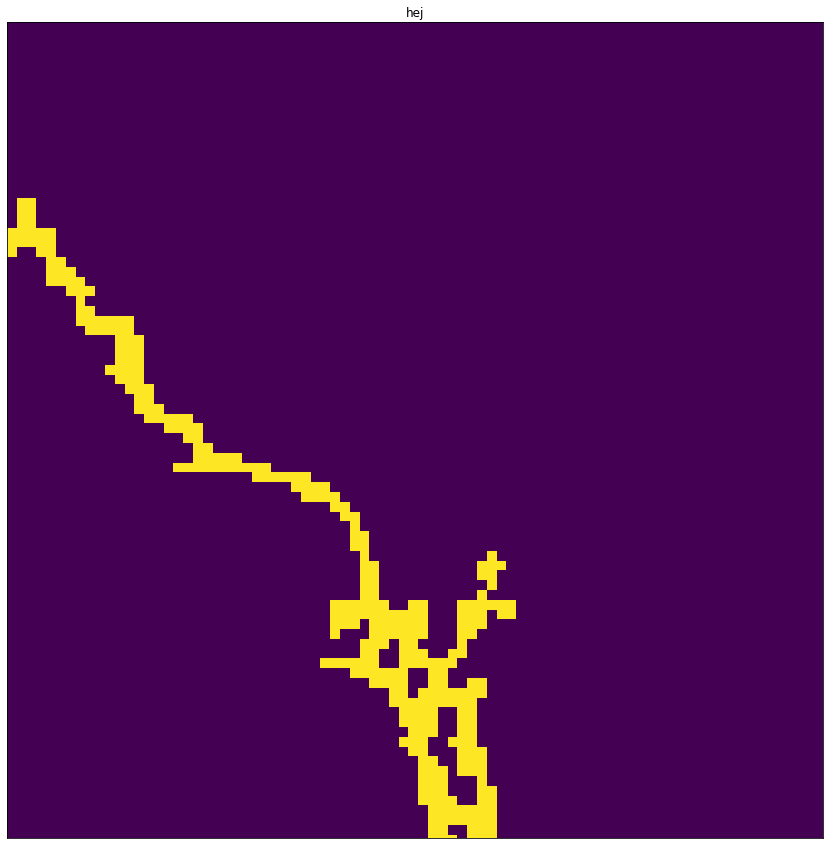

In [43]:
cut = result_with_stream[0:500,0:500]
plt.figure(num=None, figsize=(15,15), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

ax[0].title.set_text("hej")
ax[0].imshow(cut)

In [66]:
curve_arr = []
for i, row in enumerate(cut):
    for j, pixel in enumerate(row):
        if pixel == 1:
            curve_arr.append((i, j))
    

In [67]:
curve_arr

[(108, 6),
 (108, 7),
 (108, 8),
 (108, 9),
 (108, 10),
 (108, 11),
 (108, 12),
 (108, 13),
 (108, 14),
 (108, 15),
 (108, 16),
 (108, 17),
 (109, 6),
 (109, 7),
 (109, 8),
 (109, 9),
 (109, 10),
 (109, 11),
 (109, 12),
 (109, 13),
 (109, 14),
 (109, 15),
 (109, 16),
 (109, 17),
 (110, 6),
 (110, 7),
 (110, 8),
 (110, 9),
 (110, 10),
 (110, 11),
 (110, 12),
 (110, 13),
 (110, 14),
 (110, 15),
 (110, 16),
 (110, 17),
 (111, 6),
 (111, 7),
 (111, 8),
 (111, 9),
 (111, 10),
 (111, 11),
 (111, 12),
 (111, 13),
 (111, 14),
 (111, 15),
 (111, 16),
 (111, 17),
 (112, 6),
 (112, 7),
 (112, 8),
 (112, 9),
 (112, 10),
 (112, 11),
 (112, 12),
 (112, 13),
 (112, 14),
 (112, 15),
 (112, 16),
 (112, 17),
 (113, 6),
 (113, 7),
 (113, 8),
 (113, 9),
 (113, 10),
 (113, 11),
 (113, 12),
 (113, 13),
 (113, 14),
 (113, 15),
 (113, 16),
 (113, 17),
 (114, 6),
 (114, 7),
 (114, 8),
 (114, 9),
 (114, 10),
 (114, 11),
 (114, 12),
 (114, 13),
 (114, 14),
 (114, 15),
 (114, 16),
 (114, 17),
 (115, 6),
 (115, 7)